In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

In [14]:
df = pd.read_csv("/creditcard.csv")

df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
df.shape


(284807, 31)

In [16]:
df.columns


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [17]:
df['Class'].value_counts()


,count
Class,
0,284315
1,492


In [18]:
fraud_percentage = df['Class'].mean() * 100
fraud_percentage


np.float64(0.1727485630620034)

In [19]:
import imblearn
import xgboost
print("Libraries installed correctly!")


Libraries installed correctly!


In [20]:
from imblearn.over_sampling import SMOTE
print("SMOTE is ready!")


SMOTE is ready!


In [21]:
X = df.drop('Class', axis=1)
y = df['Class']

In [22]:
X['Amount_original'] = X['Amount']


In [23]:
scaler = StandardScaler()

X['Amount'] = scaler.fit_transform(X[['Amount']])


In [24]:
X[['Amount_original', 'Amount']].head()


,Amount_original,Amount
0,149.62,0.244964
1,2.69,-0.342475
2,378.66,1.160686
3,123.50,0.140534
4,69.99,-0.073403


In [25]:
X = X.drop('Amount_original', axis=1)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [27]:
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

print("Fraud rate in train:", y_train.mean())
print("Fraud rate in test:", y_test.mean())


Train size: (227845, 30)
Test size: (56962, 30)
Fraud rate in train: 0.001729245759178389
Fraud rate in test: 0.0017204452090867595


In [28]:
from sklearn.ensemble import IsolationForest


In [29]:
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.0017,
    random_state=42
)

iso_forest.fit(X_train)


IsolationForest(contamination=0.0017, random_state=42)

In [30]:
y_pred_iso = iso_forest.predict(X_test)

y_pred_iso = np.where(y_pred_iso == -1, 1, 0)


In [31]:
cm_iso = confusion_matrix(y_test, y_pred_iso)
print("Confusion Matrix (Isolation Forest):")
print(cm_iso)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_iso))


Confusion Matrix (Isolation Forest):
[[56791    73]
 [   65    33]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.31      0.34      0.32        98

    accuracy                           1.00     56962
   macro avg       0.66      0.67      0.66     56962
weighted avg       1.00      1.00      1.00     56962



In [32]:
y_scores_iso = -iso_forest.decision_function(X_test)

roc_auc_iso = roc_auc_score(y_test, y_scores_iso)
print("ROC-AUC (Isolation Forest):", roc_auc_iso)


ROC-AUC (Isolation Forest): 0.9543364475784686


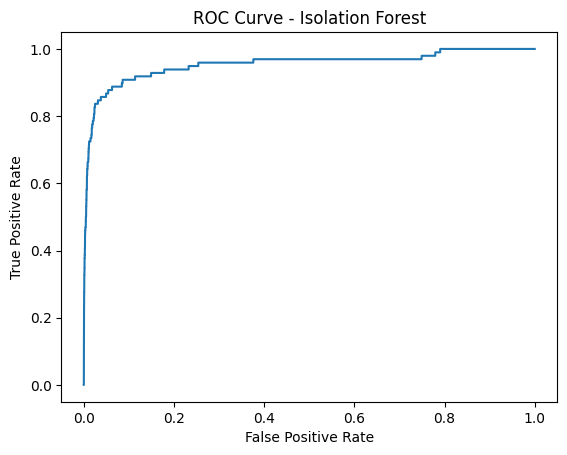

In [33]:
fpr, tpr, _ = roc_curve(y_test, y_scores_iso)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Isolation Forest")
plt.show()


In [34]:
from xgboost import XGBClassifier


In [35]:
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    eval_metric='logloss',
    random_state=42
)


In [36]:
xgb_clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [52]:
y_pred_xgb = xgb_clf.predict(X_test)

y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

print("Confusion Matrix (XGBoost without SMOTE):")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

print("\nROC-AUC:", roc_auc_score(y_test, y_proba_xgb))


Confusion Matrix (XGBoost without SMOTE):
[[56848    16]
 [   15    83]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.85      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC: 0.9765907629230646


In [38]:
from imblearn.over_sampling import SMOTE


In [39]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Avant SMOTE:", y_train.value_counts())
print("Après SMOTE:", y_train_smote.value_counts())


Avant SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
Après SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


In [40]:
xgb_smote = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)


In [41]:
xgb_smote.fit(X_train_smote, y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [42]:
y_pred_xgb_smote = xgb_smote.predict(X_test)

y_proba_xgb_smote = xgb_smote.predict_proba(X_test)[:, 1]

print("Confusion Matrix (XGBoost + SMOTE):")
print(confusion_matrix(y_test, y_pred_xgb_smote))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_smote))

print("\nROC-AUC:", roc_auc_score(y_test, y_proba_xgb_smote))


Confusion Matrix (XGBoost + SMOTE):
[[56817    47]
 [   13    85]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.64      0.87      0.74        98

    accuracy                           1.00     56962
   macro avg       0.82      0.93      0.87     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC: 0.9821536239706913


In [43]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb_smote)


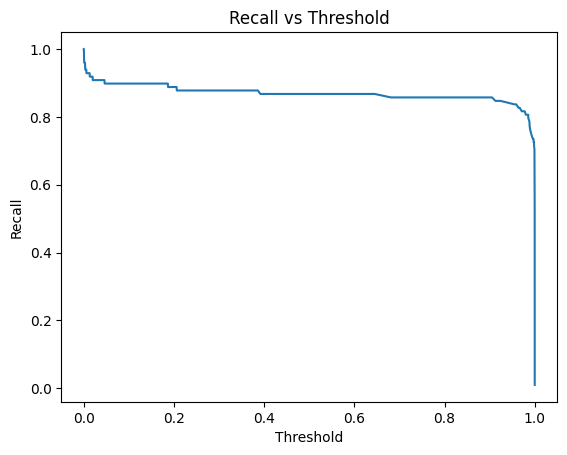

In [44]:
plt.figure()
plt.plot(thresholds, recall[:-1])
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall vs Threshold")
plt.show()


In [45]:
target_recall = 0.90

best_threshold = thresholds[recall[:-1] >= target_recall][0]
best_threshold


np.float32(7.110051e-08)

In [58]:

y_pred_opt = (y_proba_xgb_smote >= best_threshold).astype(int)

print("Confusion Matrix (Threshold optimisé):")
print(confusion_matrix(y_test, y_pred_opt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_opt))

print("\nROC-AUC:", roc_auc_score(y_test, y_proba_xgb_smote))

Confusion Matrix (Threshold optimisé):
[[56383   481]
 [    9    89]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.16      0.91      0.27        98

    accuracy                           0.99     56962
   macro avg       0.58      0.95      0.63     56962
weighted avg       1.00      0.99      0.99     56962


ROC-AUC: 0.9821536239706913


In [47]:
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-6)


In [48]:
valid_idx = recall[:-1] >= 0.90
best_idx = np.argmax(f1_scores[valid_idx])

best_threshold = thresholds[valid_idx][best_idx]
best_threshold


np.float32(0.045762047)

In [49]:
y_pred_opt = (y_proba_xgb_smote >= best_threshold).astype(int)

print("Confusion Matrix (Threshold optimisé intelligemment):")
print(confusion_matrix(y_test, y_pred_opt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_opt))

print("\nROC-AUC:", roc_auc_score(y_test, y_proba_xgb_smote))


Confusion Matrix (Threshold optimisé intelligemment):
[[56383   481]
 [    9    89]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.16      0.91      0.27        98

    accuracy                           0.99     56962
   macro avg       0.58      0.95      0.63     56962
weighted avg       1.00      0.99      0.99     56962


ROC-AUC: 0.9821536239706913


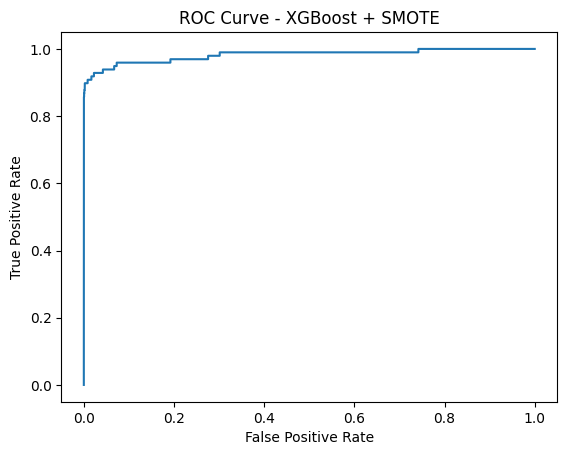

In [50]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba_xgb_smote)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost + SMOTE")
plt.show()


In [51]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()
missed_frauds = fn
total_actual_frauds = fn + tp

print(f"Number of missed frauds (False Negatives): {missed_frauds}")
print(f"Total actual fraudulent transactions: {total_actual_frauds}")


Number of missed frauds (False Negatives): 9
Total actual fraudulent transactions: 98
